In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.datasets import ImageFolder

import time

In [2]:
# dataset custom class
from PIL import Image

class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)

        image = Image.open(img_path)
        label = int(img_name.split('_')[0])

        if self.transform:
            image = self.transform(image)

        return image, label


In [3]:
# data transform and dataset initialization
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.GaussianBlur(3),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
train_dir = '/Users/bohdansynytskyi/Sound_Recognition/spoken_digits/spectrograms/train/'
val_dir = '/Users/bohdansynytskyi/Sound_Recognition/spoken_digits/spectrograms/val/'

train_dataset = SpectrogramDataset(train_dir, transform=data_transforms)
val_dataset = SpectrogramDataset(val_dir, transform=data_transforms)

In [4]:
# data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
# model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64 * 6 * 6, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

model = CNN()


In [6]:
# init function for the model
def init_cnn(module):
    if type(module)==nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

[]

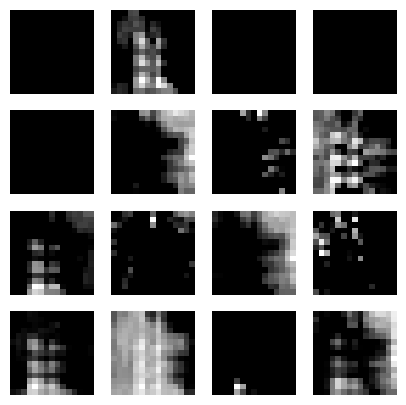

In [8]:
# channels processing pipeline
img, label = train_dataset[0]
outs = model.conv_layer[:6](img)
fig, axs = plt.subplots(4, 4, figsize=(5,5))

for i in range(16):
    axs[i//4][i%4].imshow(outs[i, :, :].detach().numpy(), cmap='gray')
    axs[i//4][i%4].axis('off')
        
plt.plot()

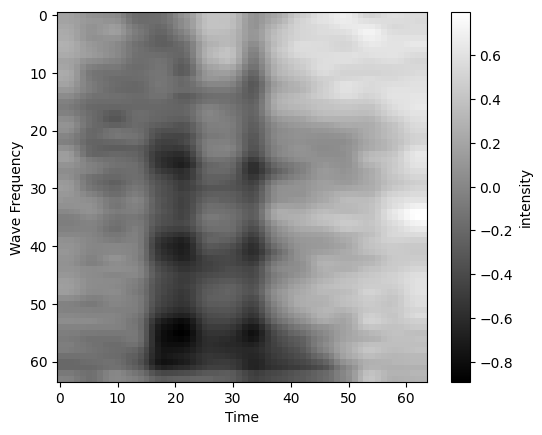

In [15]:
# spectrogram demonstration
%matplotlib inline
ax = plt.subplot()
ax = plt.imshow(img.squeeze().detach().numpy(), cmap='gray')
plt.axis('on')
plt.ylabel("Wave Frequency")
plt.xlabel("Time")
plt.colorbar(location="right", label="intensity")
plt.show()

In [7]:
# training loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

model.apply(init_cnn)

num_epochs = 10
training_losses = []
validation_losses = []
validation_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:

            outputs = model(inputs)
            validation_loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    
    epoch_loss = running_loss / len(train_dataset)
    training_losses.append(epoch_loss)
    validation_accuracies.append(accuracy)
    validation_losses.append(validation_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    print(f'Validation Accuracy: {accuracy*100:.2f}%')
    print("-------------------")



Epoch 1/10, Loss: 1.6108
Validation Accuracy: 77.67%
-------------------
Epoch 2/10, Loss: 0.7916
Validation Accuracy: 87.00%
-------------------
Epoch 3/10, Loss: 0.5524
Validation Accuracy: 92.00%
-------------------
Epoch 4/10, Loss: 0.4185
Validation Accuracy: 93.00%
-------------------
Epoch 5/10, Loss: 0.3623
Validation Accuracy: 94.33%
-------------------
Epoch 6/10, Loss: 0.3300
Validation Accuracy: 96.00%
-------------------
Epoch 7/10, Loss: 0.2877
Validation Accuracy: 96.67%
-------------------
Epoch 8/10, Loss: 0.2658
Validation Accuracy: 94.33%
-------------------
Epoch 9/10, Loss: 0.2426
Validation Accuracy: 95.67%
-------------------
Epoch 10/10, Loss: 0.1933
Validation Accuracy: 95.33%
-------------------


<IPython.core.display.Javascript object>


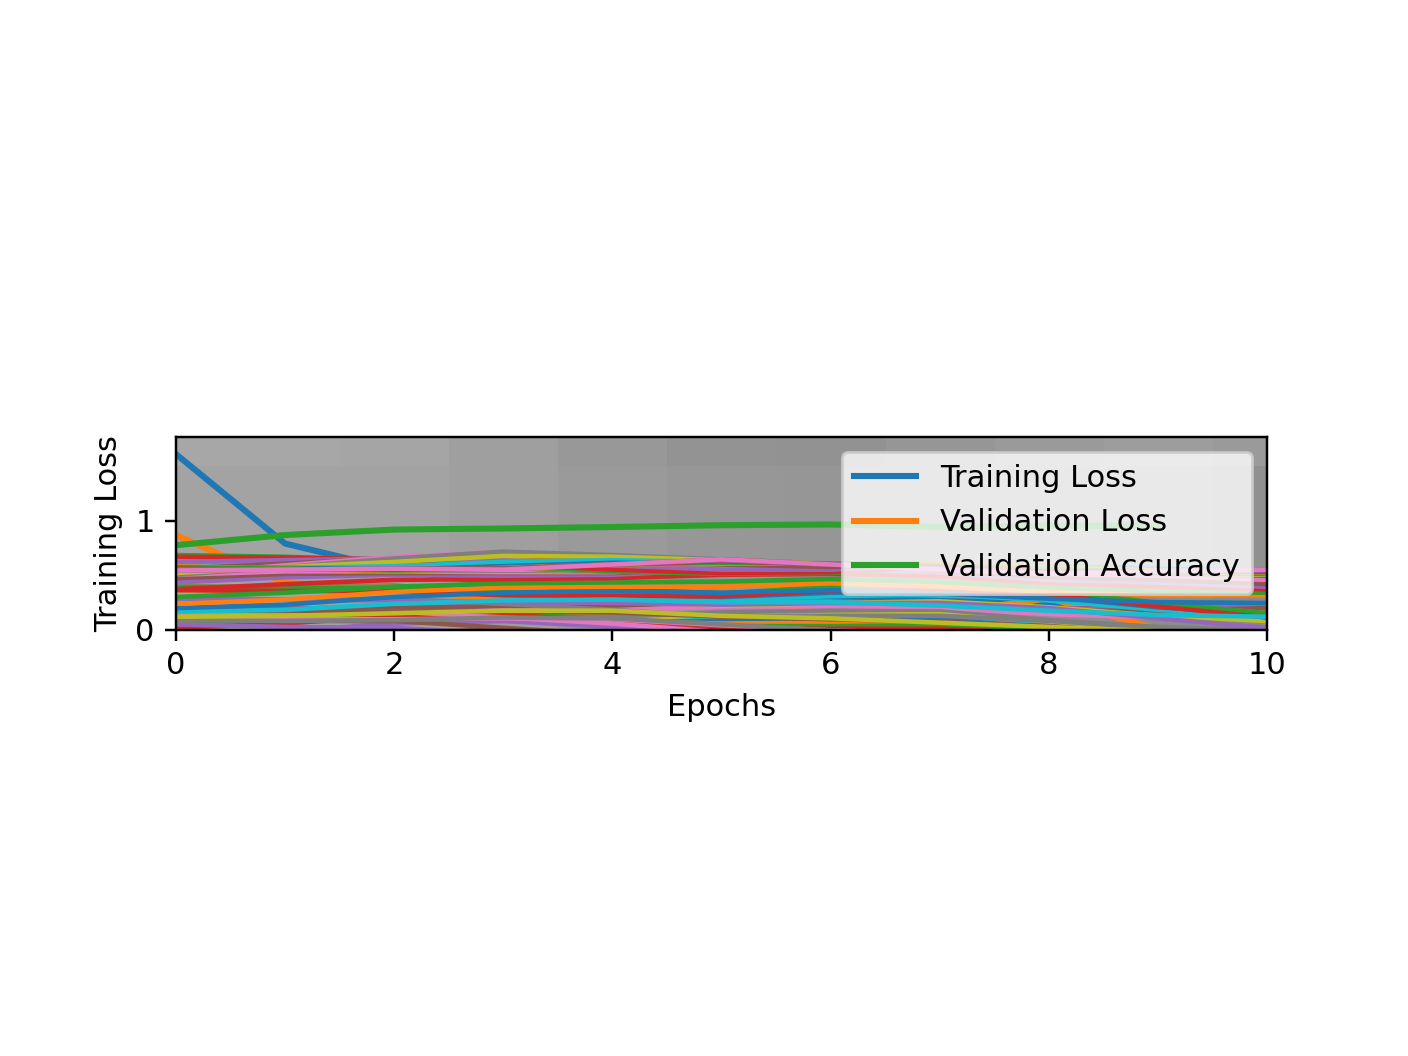

In [8]:
# cell for generating training animation
%matplotlib notebook
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()
ax.set_xlim(0, num_epochs)
ax.set_ylim(0, max(max(training_losses), max(validation_losses), max(validation_accuracies)) * 1.1)  
line1, = ax.plot([], [], lw=2, label="Training Loss")
line2, = ax.plot([], [], lw=2, label="Validation Loss")
line3, = ax.plot([], [], lw=2, label="Validation Accuracy")

ax.set_xlabel("Epochs")
ax.set_ylabel("Training Loss")
ax.legend()

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    return line1, line2, line3

def update(epoch):
    x_data = list(range(epoch + 1))
    train_data = training_losses[:epoch + 1]
    val_data = validation_losses[:epoch + 1]
    acc_data = validation_accuracies[:epoch + 1]
    line1.set_data(x_data, train_data)
    line2.set_data(x_data, val_data)
    line3.set_data(x_data, acc_data)
    return line1, line2, line3

ani = FuncAnimation(fig, update, frames=num_epochs, init_func=init, blit=False, interval=1000, repeat=False)

plt.show()
# ani.save("training_validation_loss_animation.mp4", writer="ffmpeg", fps=1)

In [18]:
# save parameters of the model
torch.save(model.state_dict(), 'cnn_spectrogram_model.pth')

In [53]:
# predicting and testing
model = CNN()
model.load_state_dict(torch.load('cnn_spectrogram_model.pth'))
model.eval()

input_dir = "/Users/bohdansynytskyi/Sound_Recognition/spoken_digits/test_spectrograms"

from PIL import Image

def predict(image_path):
    image = Image.open(image_path)
    image = data_transforms(image)

    image = image.unsqueeze(0)
    output = model(image)
    m = nn.Softmax(dim=1)
#     _, predicted = torch.max(output.data, 1)
    predicted = m(output.data)
    return predicted[0,:].detach().cpu().numpy()

for file in os.listdir(input_dir):
    if file.endswith('.png'):
        digit = predict(os.path.join(input_dir, file))
        print(f'Predicted Digit: {np.argmax(digit)}, label: {os.path.basename(file).split(".")[0]}, \nProbability distribution: {np.round(digit,3)}')
        print("--"*30)


Predicted Digit: 8, label: 8, 
Probability distribution: [0.    0.    0.    0.    0.    0.    0.011 0.    0.989 0.   ]
------------------------------------------------------------
Predicted Digit: 9, label: 9, 
Probability distribution: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
------------------------------------------------------------
Predicted Digit: 4, label: 4, 
Probability distribution: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
------------------------------------------------------------
Predicted Digit: 5, label: 5, 
Probability distribution: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
------------------------------------------------------------
Predicted Digit: 4, label: 7, 
Probability distribution: [0.    0.131 0.    0.    0.586 0.282 0.    0.    0.    0.   ]
------------------------------------------------------------
Predicted Digit: 6, label: 6, 
Probability distribution: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
------------------------------------------------------------
Predicted Digit: 0, label: 2, 
Probabili